# **Checking the GPU we are currently using**

In [1]:
!nvidia-smi

Wed Nov 27 12:52:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
pip uninstall tensorflow -y


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0


In [3]:
pip install tensorflow==2.15.0


  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


In [4]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [5]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3ca2bc1f-fe8e-e5c0-c2a1-bd80953bee0a)


# **Installing transformers, datasets and numpy library**

In [6]:
!pip install transformers datasets numpy > /dev/null

In [7]:
!pip install evaluate


# **Importing required libraries and modules**

In [8]:
import numpy as np

from datasets import (
    load_dataset,
    DatasetDict,
    Dataset,
)

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)

# **Setting Constants**:
We're going to use SEED, for shuffling our dataset, transformer models and everywhere we use something that is done randomly so we get the same result each time. CHECKPOINT is used to when we load the model and the tokenizer of the model, you can simply change the CHECKPOINT to a similiar model and run this whole notebook and it will work; for example you can change it to bert-base-uncased.

In [9]:
SEED = 1000
CHECKPOINT = "distilbert-base-uncased"

# **Loading sst2 Dataset from glue Benchmark**

In [10]:
sst2_datasets = load_dataset("glue", "sst2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# **Creating a Smaller Version of sst2 Dataset**

In [11]:
select_example = sst2_datasets["train"].select(range(300))

custom_sst2 = DatasetDict({
    "train": sst2_datasets["train"].shuffle(seed=SEED).select(range(1000)).flatten_indices(),
    "validation": sst2_datasets["validation"],
    "test": sst2_datasets["train"].shuffle(seed=SEED).select(range(300, 400)).flatten_indices()
})

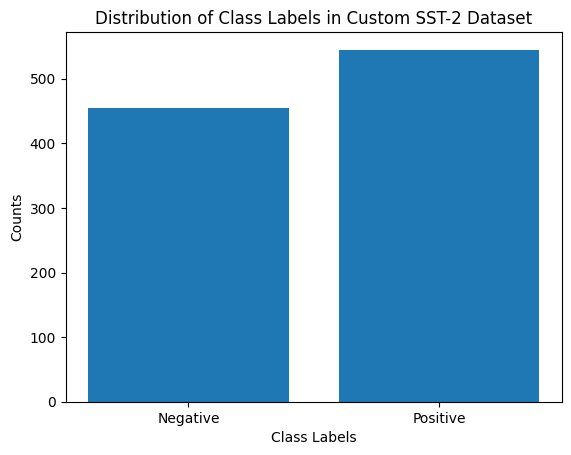

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a Pandas DataFrame to store the class labels and their counts
labels = ["Negative", "Positive"]
train_counts = [len(custom_sst2["train"].filter(lambda example: example["label"] == 0)),
                len(custom_sst2["train"].filter(lambda example: example["label"] == 1))]
data = {"Class Labels": labels, "Counts": train_counts}
df = pd.DataFrame(data)

# Plot the bar chart using matplotlib
plt.bar(df["Class Labels"], df["Counts"])

# Set the labels and title
plt.xlabel("Class Labels")
plt.ylabel("Counts")
plt.title("Distribution of Class Labels in Custom SST-2 Dataset")

# Show the plot
plt.show()


# **Defining Compute Metric**

In [13]:
from sklearn.metrics import accuracy_score


# **Set Transformers Seed**
If we don't set the seed, the first time we train a model, the transformers library is going to set a seed itself. more information about this: https://discuss.huggingface.co/t/multiple-training-will-give-exactly-the-same-result-except-for-the-first-time/8493?u=smmousavi

In [14]:
set_seed(SEED)

In [15]:
!pip install torch

In [16]:
!pip install transformers[torch]
!pip install accelerate -U


In [17]:
!pip install sklearn --upgrade

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install torch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizer
from datasets import load_dataset
import numpy as np
import torch
import time
import random
from torch.utils.data import DataLoader

# Load SST-2 dataset
dataset = load_dataset("glue", "sst2")

# Initialize the DistilBERT model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# Tokenizing the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Compute Metrics function (example)
def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).mean()
    return {"accuracy": accuracy}

# Placeholder functions for computational cost, inference time, and energy consumption
def compute_computational_cost(model):
    # Placeholder: Let's assume the cost is proportional to the number of parameters
    return sum(p.numel() for p in model.parameters())  # Count the total number of parameters

def compute_inference_time(model, input_data):
    # Placeholder: Simulate inference time by random values
    start_time = time.time()
    _ = model(input_data)
    return time.time() - start_time

def compute_energy_consumption(model):
    # Placeholder: Estimate energy consumption based on model size
    return sum(p.numel() for p in model.parameters()) * random.uniform(0.01, 0.05)  # Random factor for energy

def compute_accuracy(model, dataset):
    # Compute accuracy on the SST-2 dataset
    model.eval()
    correct = 0
    total = 0
    for batch in DataLoader(dataset, batch_size=8, shuffle=False):
        inputs = batch["input_ids"].to(model.device)
        labels = batch["label"].to(model.device)
        with torch.no_grad():
            outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, dim=-1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return correct / total

def prune_model_weights(model, pruning_ratio):
    """
    Prune the model's weights by removing the smallest weights according to the pruning ratio.
    """
    pruned_model = model
    for name, param in pruned_model.named_parameters():
        if "weight" in name and param.requires_grad:
            flattened_weights = param.abs().flatten()
            threshold_index = int(len(flattened_weights) * pruning_ratio)
            sorted_weights, _ = torch.sort(flattened_weights)
            threshold = sorted_weights[threshold_index]
            param.data[param.abs() < threshold] = 0
    return pruned_model

def optimize_pruning(model, target_pruning_ratio=0.7, epsilon=0.05):
    # Step 1: Initialize original model weights
    A_W = compute_accuracy(model, tokenized_datasets["validation"])  # Accuracy of the original model
    C_W = compute_computational_cost(model)  # Computational cost of the original model
    T_W = compute_inference_time(model, tokenized_datasets["validation"])  # Inference time of the original model
    E_W = compute_energy_consumption(model)  # Energy consumption of the original model
    print(f"Original Accuracy: {A_W}, Cost: {C_W}, Time: {T_W}, Energy: {E_W}")

    # Step 2: Prune the model
    pruned_model = prune_model_weights(model, target_pruning_ratio)
    A_W_prime = compute_accuracy(pruned_model, tokenized_datasets["validation"])  # Accuracy of the pruned model
    C_W_prime = compute_computational_cost(pruned_model)  # Computational cost of the pruned model
    T_W_prime = compute_inference_time(pruned_model, tokenized_datasets["validation"])  # Inference time of the pruned model
    E_W_prime = compute_energy_consumption(pruned_model)  # Energy consumption of the pruned model
    print(f"Pruned Accuracy: {A_W_prime}, Cost: {C_W_prime}, Time: {T_W_prime}, Energy: {E_W_prime}")

    # Step 3: Verify accuracy
    if A_W_prime >= A_W - epsilon:
        print(f"Accuracy after pruning is within acceptable range (>= {A_W - epsilon})")
    else:
        print("Accuracy after pruning is too low, stopping optimization.")
        return None  # Return None to indicate pruning was unsuccessful

    # Step 4: Measure efficiency
    if C_W_prime < C_W and T_W_prime < T_W and E_W_prime < E_W:
        print("Model efficiency improved!")
    else:
        print("Model efficiency did not improve.")

    # Step 5: Optimize pruning ratio if necessary (optional)
    best_pruned_model = pruned_model
    best_accuracy = A_W_prime
    best_pruning_ratio = target_pruning_ratio

    for i in range(5):  # Run for a few iterations to optimize pruning ratio
        target_pruning_ratio += 0.05  # Increment pruning ratio
        pruned_model = prune_model_weights(model, target_pruning_ratio)
        A_W_prime = compute_accuracy(pruned_model, tokenized_datasets["validation"])

        if A_W_prime >= A_W - epsilon and A_W_prime > best_accuracy:
            best_accuracy = A_W_prime
            best_pruned_model = pruned_model
            best_pruning_ratio = target_pruning_ratio

    print(f"Best Pruning Ratio: {best_pruning_ratio}, Best Accuracy: {best_accuracy}")

    return best_pruned_model, best_accuracy, C_W_prime, T_W_prime, E_W_prime


# Define training arguments
training_args = TrainingArguments(
    output_dir="custom_sst2_distilbert",  # Directory to save the model
    load_best_model_at_end=True,
    num_train_epochs=3,
    eval_strategy="steps",  # Updated to eval_strategy
    eval_steps=100,
    save_steps=100,
    metric_for_best_model="accuracy",
    save_total_limit=10,
)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# After training, optimize pruning
best_pruned_model, best_accuracy, optimized_cost, optimized_time, optimized_energy = optimize_pruning(
    model,
    target_pruning_ratio=0.7,  # Set 70% pruning
    epsilon=0.05  # Acceptable accuracy loss threshold
)

if best_pruned_model:
    print("Optimization successful!")
    # Save the pruned model
    best_pruned_model.save_pretrained("best_pruned_model")
else:
    print("Optimization failed!")
